# Feeltrace Proceesing Notebook

This notebook contains the functions for processing the feeltrace:

1. Interpolation of the feeltrace signal
2. Windowing function
3. emotion-as-position
4. emotion-as-accumulation
5. emotion-as-angle

In [1]:
# import some useful libraries

import os
import glob

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd

from scipy import signal


# model creation
import torch.nn as nn
import torch.nn.functional as F
import torch

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import StratifiedKFold

# loading bar
from tqdm import tqdm

# kalman filter
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import KalmanFilter


/home/bkat/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Dataset

In [2]:
dir = '../feeltrace' # directory containing *.csv files
# hyper parameters
window_size = 500 # must be an int in milliseconds
subject_num = 1 # which subject to choose [1-16]
k_fold = 5 # k for k fold validation
apply_kf = True # apply kalman filter
num_classes = 3 # number of classes to discretize the labels into

In [3]:
# functions for preprocessing dataset

def load_dataset(dir = 'feeltrace', subject_num = 5, interpolate=False, resample_period='33ms'):
    # choose the subject
    subject_data_files = glob.glob(os.path.join(dir, '*.csv'))
    # sort the files by the index given to them
    file_name_2_index = lambda file : int(file.split('.csv')[0].split('_')[-1])
    subject_data_files.sort() # sort alphabetically
    subject_data_files.sort(key=file_name_2_index) # sort by index
    eeg_ft = subject_data_files[subject_num-1]

    print(f"Chosen subject: {eeg_ft}")
    
    data_signal = pd.read_csv(eeg_ft) # read the Nx2 data for a single subject

    if interpolate:
        data_signal = interpolate_df(data_signal, resample_period=resample_period)

    # return signal
    return data_signal

def interpolate_df(df, timestamps='t', resample_period='33ms'):
    '''
    resample and fill in nan values using zero hold
    '''
    df[timestamps] = pd.to_datetime(df[timestamps], unit='s')
    df_time_indexed = df.set_index(timestamps)
    df_padded = df_time_indexed.resample(resample_period, origin='start') # resample
    df_padded = df_padded.ffill() # fill nan values with the previous valid value
    df_padded.reset_index(inplace=True)
    df_padded[timestamps] = df_padded[timestamps].astype('int64') / 1e9 # nano second to seconds
    return df_padded

def apply_kalman(raw_label, dt=1e-3, R=1e2, var=1e2, p=1e2):
    kf = KalmanFilter(dim_x=2, dim_z=1)

    kf.x = np.array([[0.5],
                [0.]])       # initial state (location and angle)

    kf.F = np.array([[1.,dt],
                [0.,1.]])    # state transition matrix

    kf.H = np.array([[1.,1.]])    # Measurement function
    kf.P = np.array([[p,    0.],
                [   0., p] ])               # covariance matrix
    kf.R = R                      # state uncertainty
    kf.Q = Q_discrete_white_noise(dim=2, dt=dt, var=var) # process uncertainty

    kf_signal = np.zeros_like(raw_label)
    for i,m in enumerate(raw_label):
        kf.predict() # predict
        kf.update(m) # measure
        x = np.clip(kf.x[0], 0,1)
        kf_signal[i] = x
    return kf_signal

def generate_label(feeltrace, split_size=100, k=5, label_type='angle', num_classes=3, kf=False):
    
    # split into windows (non-overlapping)
    dataset = [feeltrace[x : x + split_size] for x in range(0, len(feeltrace), split_size)]
    if len(dataset[-1]) < split_size:
        dataset.pop() # remove last window if it is smaller than the rest

    if label_type != 'both':
        labels, raw_label = get_label(dataset, n_labels=num_classes, label_type=label_type, kf=kf, dt=split_size/1000) # (N, 1)
    else:
        labels, raw_label = get_combined_label(dataset, n_labels=int(np.sqrt(num_classes))) # (N, 1)

    print(f"label set shape (N,):  {labels.shape}")

    indices = split_dataset(labels, k=k) # split data into train/test indices using kFold validation
    return labels, indices, raw_label


def get_label(data, n_labels=3, label_type='angle', kf=False, dt=1e-3):
    if label_type == 'angle':
        labels = stress_2_angle(np.vstack([x[:,1].T for x in data])) # angle/slope mapped to [0,1] in a time window
    elif label_type == 'pos':
        labels = np.vstack([x[:,1].mean() for x in data]) # mean value within the time window
    else:
        labels = stress_2_accumulator(np.vstack([x[:,1].T for x in data])) # accumulator mapped to [0,1] in a time window
        
    if kf:
        labels = apply_kalman(labels, dt, R=1e3, var=1e3, p=1e3)
        
    label_dist = stress_2_label(labels, n_labels=n_labels).squeeze()
    return label_dist, labels.squeeze()

def get_combined_label(data, n_labels=3):
    angle_labels, _ = get_label(data, n_labels=n_labels, label_type='angle') # (N, 1)
    pos_labels, _ = get_label(data, n_labels=n_labels, label_type='pos') # (N, 1)

    labels = [x for x in range(n_labels)]
    labels_dict =  {(a, b) : n_labels*a+b for a in labels for b in labels} # cartesian product
    combined_labels = [labels_dict[(pos, angle)] for (pos, angle) in zip(pos_labels, angle_labels)]
    return np.array(combined_labels)


def stress_2_label(mean_stress, n_labels=5):
    # value is in [0,1] so map to [0,labels-1] and discretize
    return np.digitize(mean_stress * n_labels, np.arange(n_labels)) - 1

def stress_2_angle(stress_windows):
    '''
    do a linear least squares fit in the time window
    stress_window: (N_samples, time_window)
    '''
    xvals = np.arange(stress_windows.shape[-1])/1e3/60 # time in (minutes)
    slope = np.polyfit(xvals, stress_windows.T, 1)[0] # take slope linear term # 1/s
    angle = np.arctan(slope)/ (np.pi/2) * 0.5 + 0.5 # map to [0,1]
    return angle

def stress_2_accumulator(stress_windows):
    '''
    apply an integral to the time window
    stress_window: (N_samples, time_window)
    '''
    max_area = stress_windows.shape[-1]
    xvals = np.arange(stress_windows.shape[-1]) # time in (ms)
    integral = np.trapz(stress_windows, x=xvals)
    return integral/max_area # map to [0,1]

def split_dataset(labels, k=5):
    '''
    split the features and labels into k groups for k fold validation
    we use StratifiedKFold to ensure that the class distributions within each sample is the same as the global distribution
    '''
    kf = StratifiedKFold(n_splits=k, shuffle=True)

    # only labels are required for generating the split indices so we ignore it
    temp_features = np.zeros_like(labels)
    indices = [(train_index, test_index) for train_index, test_index in kf.split(temp_features, labels)]
    return indices

In [4]:
ft_signal = load_dataset(dir = dir, subject_num = subject_num, interpolate=True, resample_period='1ms')
ft = ft_signal.values
ft_signal

Chosen subject: ../feeltrace/feeltrace_0.csv


,t,stress
0,-12.397,0.324444
1,-12.396,0.324444
2,-12.395,0.324444
3,-12.394,0.324444
4,-12.393,0.324444
...,...,...
969560,957.163,0.320000
969561,957.164,0.320000
969562,957.165,0.320000
969563,957.166,0.320000


In [10]:
labels, indices, kf_raw_label = generate_label(ft, split_size=window_size, k=k_fold, label_type='pos', num_classes=num_classes, kf=apply_kf)

_, _, kf_raw_pos_labels = generate_label(ft, split_size=window_size, k=k_fold, label_type='pos', num_classes=num_classes, kf=apply_kf)
_, _, kf_raw_angle_labels = generate_label(ft, split_size=window_size, k=k_fold, label_type='angle', num_classes=num_classes, kf=apply_kf)
_, _, kf_raw_accumulator_labels = generate_label(ft, split_size=window_size, k=k_fold, label_type='accumulator', num_classes=num_classes, kf=apply_kf)

_, _, raw_pos_labels = generate_label(ft, split_size=window_size, k=k_fold, label_type='pos', num_classes=num_classes)
_, _, raw_angle_labels = generate_label(ft, split_size=window_size, k=k_fold, label_type='angle', num_classes=num_classes)
_, _, raw_accumulator_labels = generate_label(ft, split_size=window_size, k=k_fold, label_type='accumulator', num_classes=num_classes)


label_dict = {
    "window" : np.arange(len(raw_pos_labels)),
    "kf_pos": kf_raw_pos_labels.tolist(),
    "kf_angle": kf_raw_angle_labels.tolist(),
    "kf_accumulator": kf_raw_accumulator_labels.tolist(),
    "pos": raw_pos_labels.tolist(),
    "angle": raw_angle_labels.tolist(),
    "accumulator": raw_accumulator_labels.tolist()
}

label_df = pd.DataFrame(label_dict)


label set shape (N,):  (1939,)
label set shape (N,):  (1939,)
label set shape (N,):  (1939,)
label set shape (N,):  (1939,)
label set shape (N,):  (1939,)
label set shape (N,):  (1939,)
label set shape (N,):  (1939,)


In [8]:

# label_df[ (label_df['pos'] >= 0.3) & (label_df['pos'] <= 0.32)]

In [11]:
label_df.head()

,window,kf_pos,kf_angle,kf_accumulator,pos,angle,accumulator
0,0,0.430316,0.502269,0.430061,0.323111,0.505761,0.322462
1,1,0.394756,0.475794,0.394370,0.322907,0.403110,0.322258
2,2,0.367681,0.477441,0.367195,0.323049,0.502938,0.322400
3,3,0.348607,0.496812,0.348053,0.322311,0.562085,0.321662
4,4,0.336348,0.451969,0.335750,0.322267,0.298337,0.321622


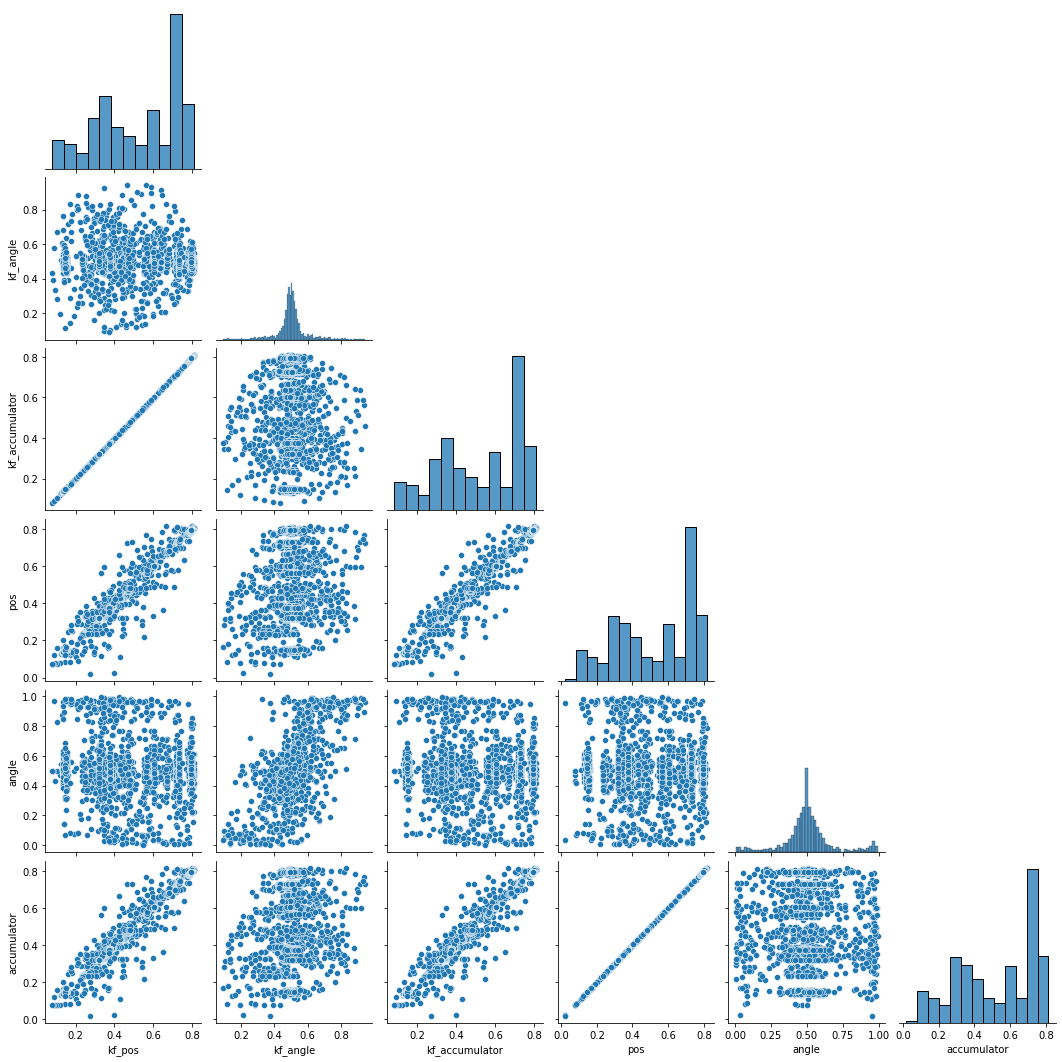

In [6]:
import seaborn as sns
g = sns.pairplot(data=label_df[["kf_pos", "kf_angle", "kf_accumulator", "pos", "angle", "accumulator"]], corner=True)
plt.show()
del g

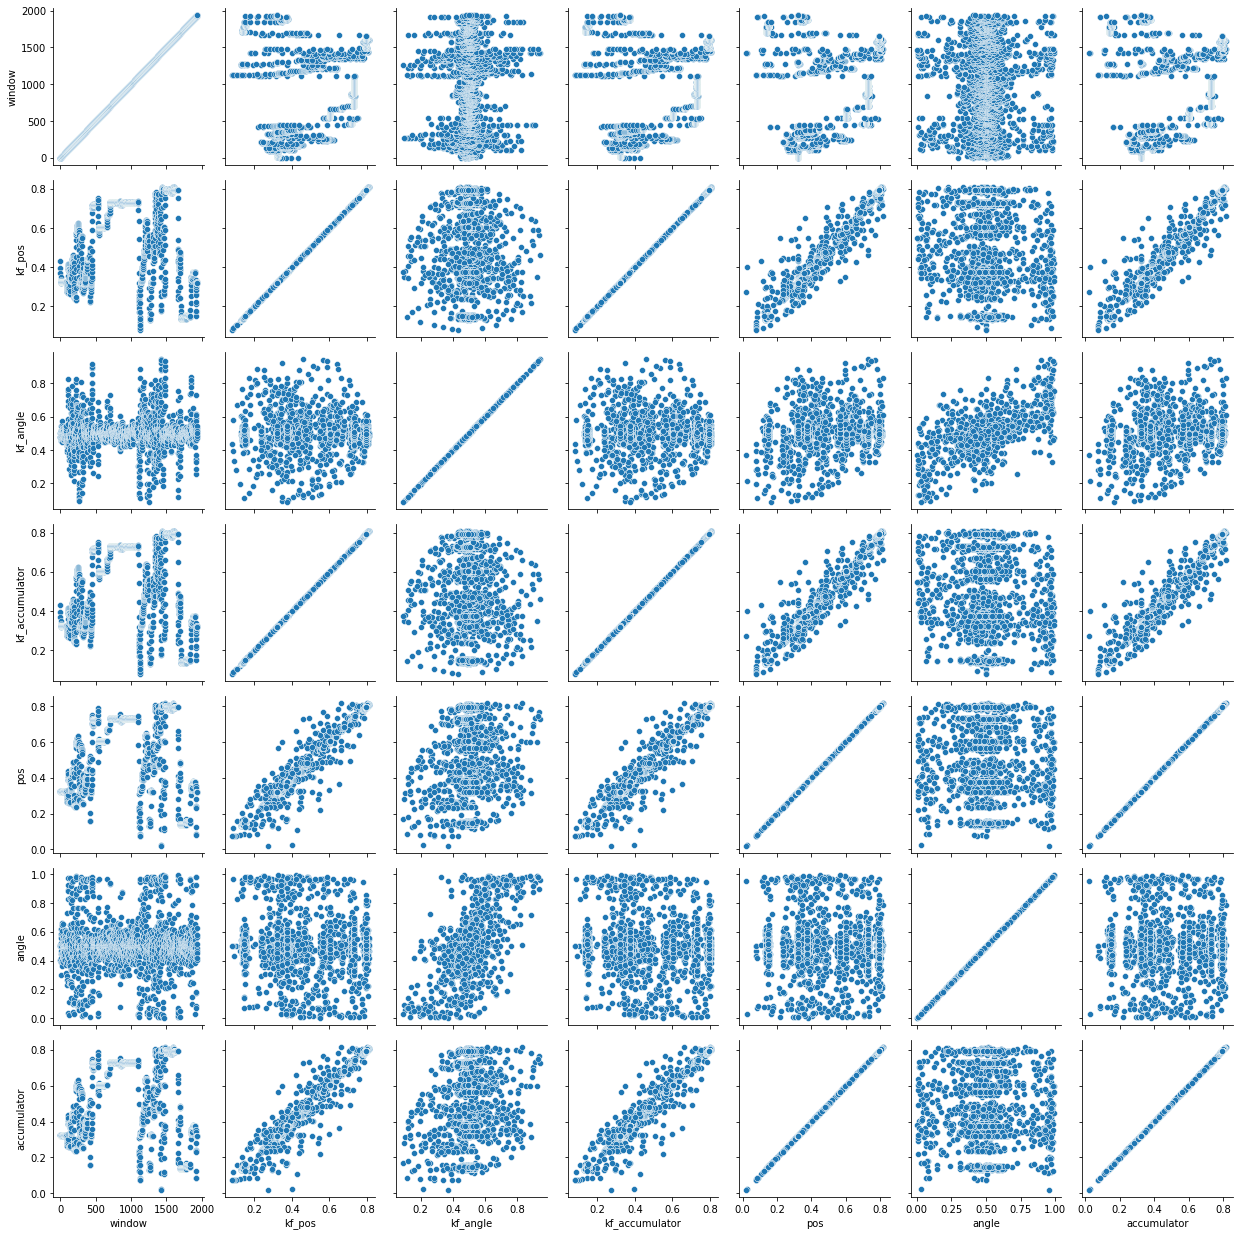

In [14]:
# sns.scatterplot(x="carat", y="price",
#                 hue="clarity", size="depth",
#                 palette="ch:r=-.2,d=.3_r",
#                 hue_order=clarity_ranking,
#                 sizes=(1, 8), linewidth=0,
#                 data=diamonds, ax=ax)

# g = sns.scatter(data=label_df[["kf_pos", "kf_angle", "kf_accumulator", "pos", "angle", "accumulator"]], corner=True)
# plt.show()
# del g

g = sns.PairGrid(label_df)
g.map(sns.scatterplot)
plt.show()
del g

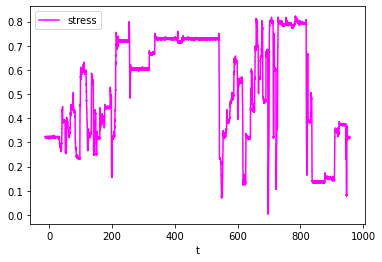

In [7]:
ft_signal.plot(kind='line',x='t', y='stress', color='magenta')
plt.show()